In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import networkx as nx
from scipy.ndimage import gaussian_filter1d
from pathlib import Path
from tqdm.notebook import tqdm
from artemutils.colormaps import get_colormap
import matplotlib
# Enable TeX rendering in matplotlib
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

import neo
import elephant
import quantities as pq
import numpy as np
from elephant.statistics import instantaneous_rate

np.random.seed(42)

def generate_rate_functions(n_neurons, n_times, length_scale=100):
    """Generate smooth rate functions using a Gaussian process."""
    times = np.linspace(0, 1, n_times)
    K = np.exp(-((times[:, None] - times[None, :]) ** 2) / (2 * (length_scale/n_times) ** 2))
    rates = np.random.multivariate_normal(np.zeros(n_times), K, size=n_neurons)
    rates = np.exp(rates / 2) * 0.05
    return rates

def gaussian(x, mu, sigma):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

def generate_spikes(rates, dt):
    """Generate spikes from inhomogeneous Poisson process."""
    return np.random.rand(*rates.shape) < rates * dt

In [ ]:
def project_to_saddle(points_2d, saddle_size, saddle_height):
    """
    Project an array from 2D intrinsic coords onto the saddle surface in 3D
    
    Args:
        points_2d (array): 2D coordinates to project onto the saddle surface. Shape (n_points, 2)
        size (float): Size of the saddle surface
        amplitude (float): Height of the saddle
    
    Returns:
        Vector: 3D point on the saddle surface
    """
    assert points_2d.min() >= -1 and points_2d.max() <= 1 # Check that points are in the right range for 2D intrinsic coords
    x,y= points_2d.T
    z = saddle_height * (x**2 - y**2) / saddle_size**2
    return np.array([x, y, z]).T

In [45]:
dt = 0.01
t_stop = 5
time = np.arange(0, 5, dt)

rates = [
    gaussian(time, 2.5, 1)*15,
    gaussian(time, 1.5, 0.5)*10,
    gaussian(time, 3.5, 0.5)*10,
]

spikes = [
    time[generate_spikes(rate, dt)] for rate in rates
]

def get_inst_rate(spike_times):
    spiketrain = neo.SpikeTrain(spike_times * pq.s, t_stop=t_stop * pq.s, t_start=0 * pq.s)
    sampling_period = 0.01 * pq.s  # 10ms sampling
    kernel_sigma = 0.2 * pq.s     # 50ms kernel width

    inst_rate = instantaneous_rate(spiketrain, 
                                sampling_period=sampling_period,
                                kernel=elephant.kernels.GaussianKernel(kernel_sigma),
                                trim=False)
    t = inst_rate.times.magnitude
    inst_rate = inst_rate.as_array()[:,0]

    # Interpolate to get the same time points as the rate functions
    inst_rate = np.interp(time, t, inst_rate, left=0, right=0)
    return inst_rate

inst_rates = [get_inst_rate(s) for s in spikes]

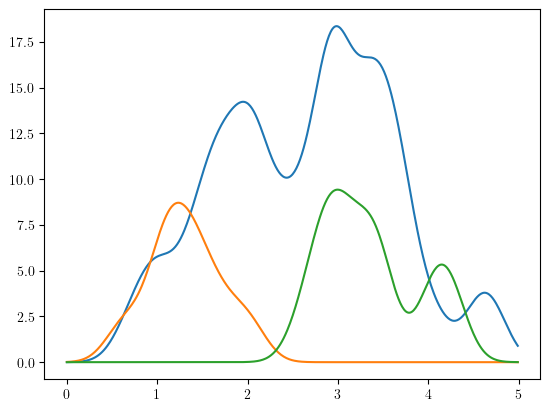

In [46]:
plt.plot(time, inst_rates[0])
plt.plot(time, inst_rates[1])
plt.plot(time, inst_rates[2]) 

In [49]:
def animate_spike_train(time, spikes, save_folder, color='white', suffix=1):
    save_folder = Path(save_folder)
    save_folder.mkdir(exist_ok=True, parents=True)

    fig, ax = plt.subplots(1,1, figsize=(10, 3), dpi=200)
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')
    kw = dict(linelengths=2, linewidths=2)
    ax.eventplot(spikes, color='black', **kw) # This is to set the limits
    ax.set_xlim(0, t_stop)
    event_collection = ax.eventplot([], color=color, **kw)
    
    def update(timestamp):
        visible_spikes = spikes[spikes <= timestamp]
        event_collection[0].set_positions(visible_spikes)
        return event_collection

    anim = FuncAnimation(fig, update, frames=tqdm(time), blit=True, interval=30)
    anim.save(save_folder / f'spike_train_{suffix}.mp4')


def animate_rate(time, inst_rate, save_folder, color='white', suffix=1):
    save_folder = Path(save_folder)
    save_folder.mkdir(exist_ok=True, parents=True)

    fig, ax = plt.subplots(1,1, figsize=(10, 3), dpi=200)
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')

    ax.set_xlabel('Time (s)', color='white', fontsize=15)
    ax.set_ylabel('Neuron firing rate (Hz)', color='white', fontsize=15)
    ax.tick_params(axis='x', colors='white', labelsize=13)
    ax.tick_params(axis='y', colors='white', labelsize=13)

    ax.plot(time, inst_rate, color='black', lw=3, solid_capstyle='round') # This is to set the limits
    line = ax.plot([], [], color=color, lw=3, solid_capstyle='round')[0]
    
    def update(timestamp):
        line.set_data(time[time <= timestamp], inst_rate[time <= timestamp])
        # Remove previous fill_between
        if len(ax.collections) > 0:
            for collection in ax.collections:
                collection.remove()
        fill = ax.fill_between(time[time <= timestamp], inst_rate[time <= timestamp], color=color, alpha=0.25)
        return line, fill

    fig.tight_layout()
    anim = FuncAnimation(fig, update, frames=tqdm(time), blit=True, interval=30)
    anim.save(save_folder / f'rate_{suffix}.mp4')

    # update(time[-1])
    # plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

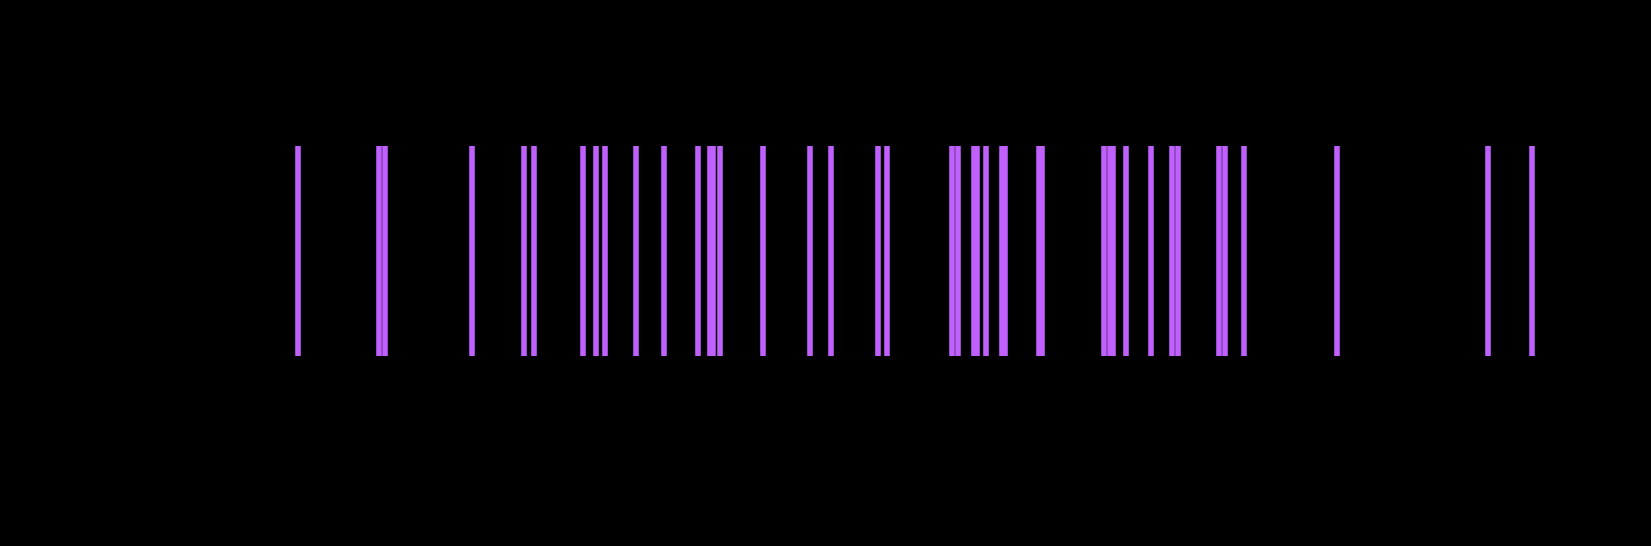

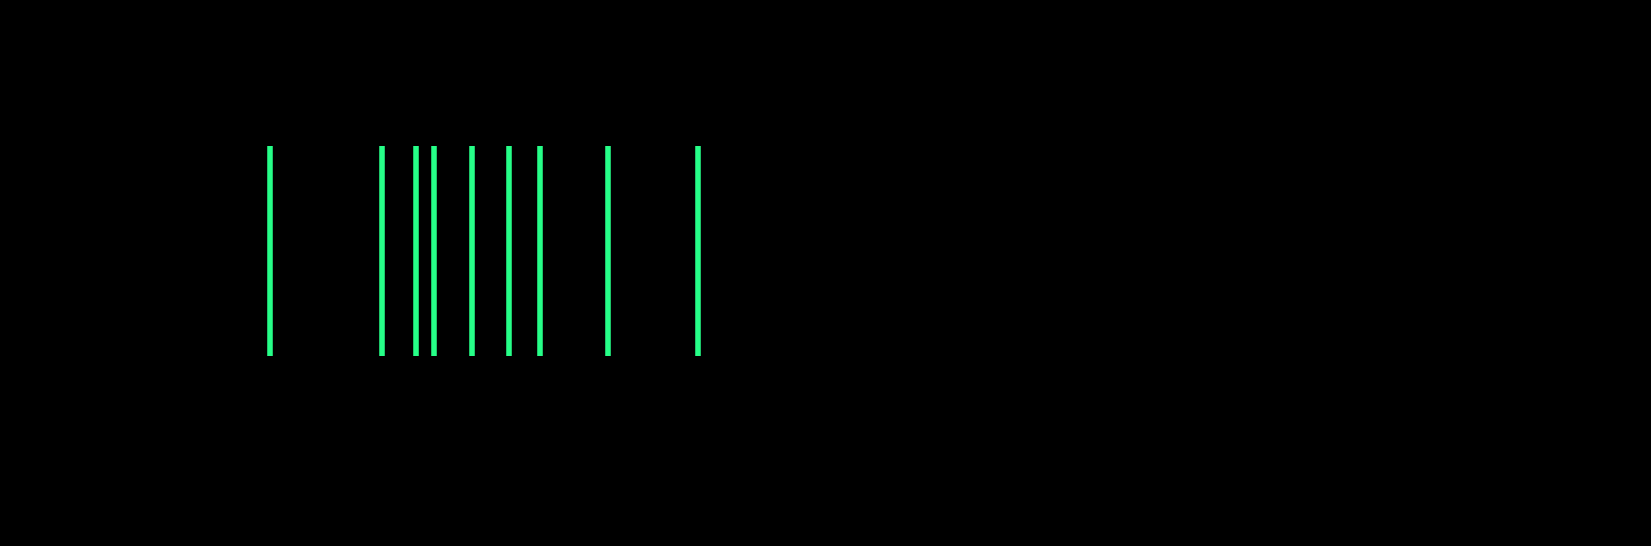

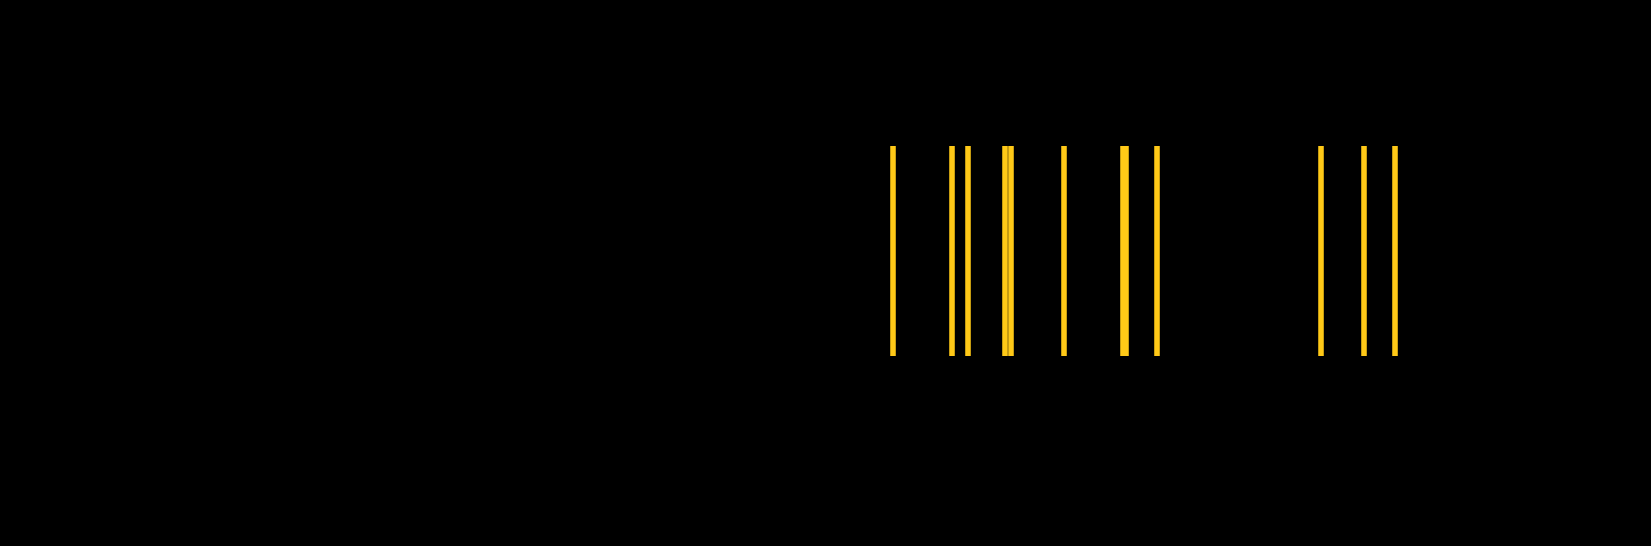

In [50]:
save_folder = Path('/Users/artemkirsanov/YouTube/SWR memory selection/Code/animations/single_neuron_state_space')
#animate_spike_train(time, spike_times, save_folder, color='#c061ff')

colors = ['#c061ff', '#26ff88', '#ffc917']


for i in range(3):
  #  animate_rate(time, inst_rates[i], save_folder, color=colors[i], suffix=i+1)
    animate_spike_train(time, spikes[i], save_folder, color=colors[i], suffix=i+1)

  0%|          | 0/300 [00:00<?, ?it/s]

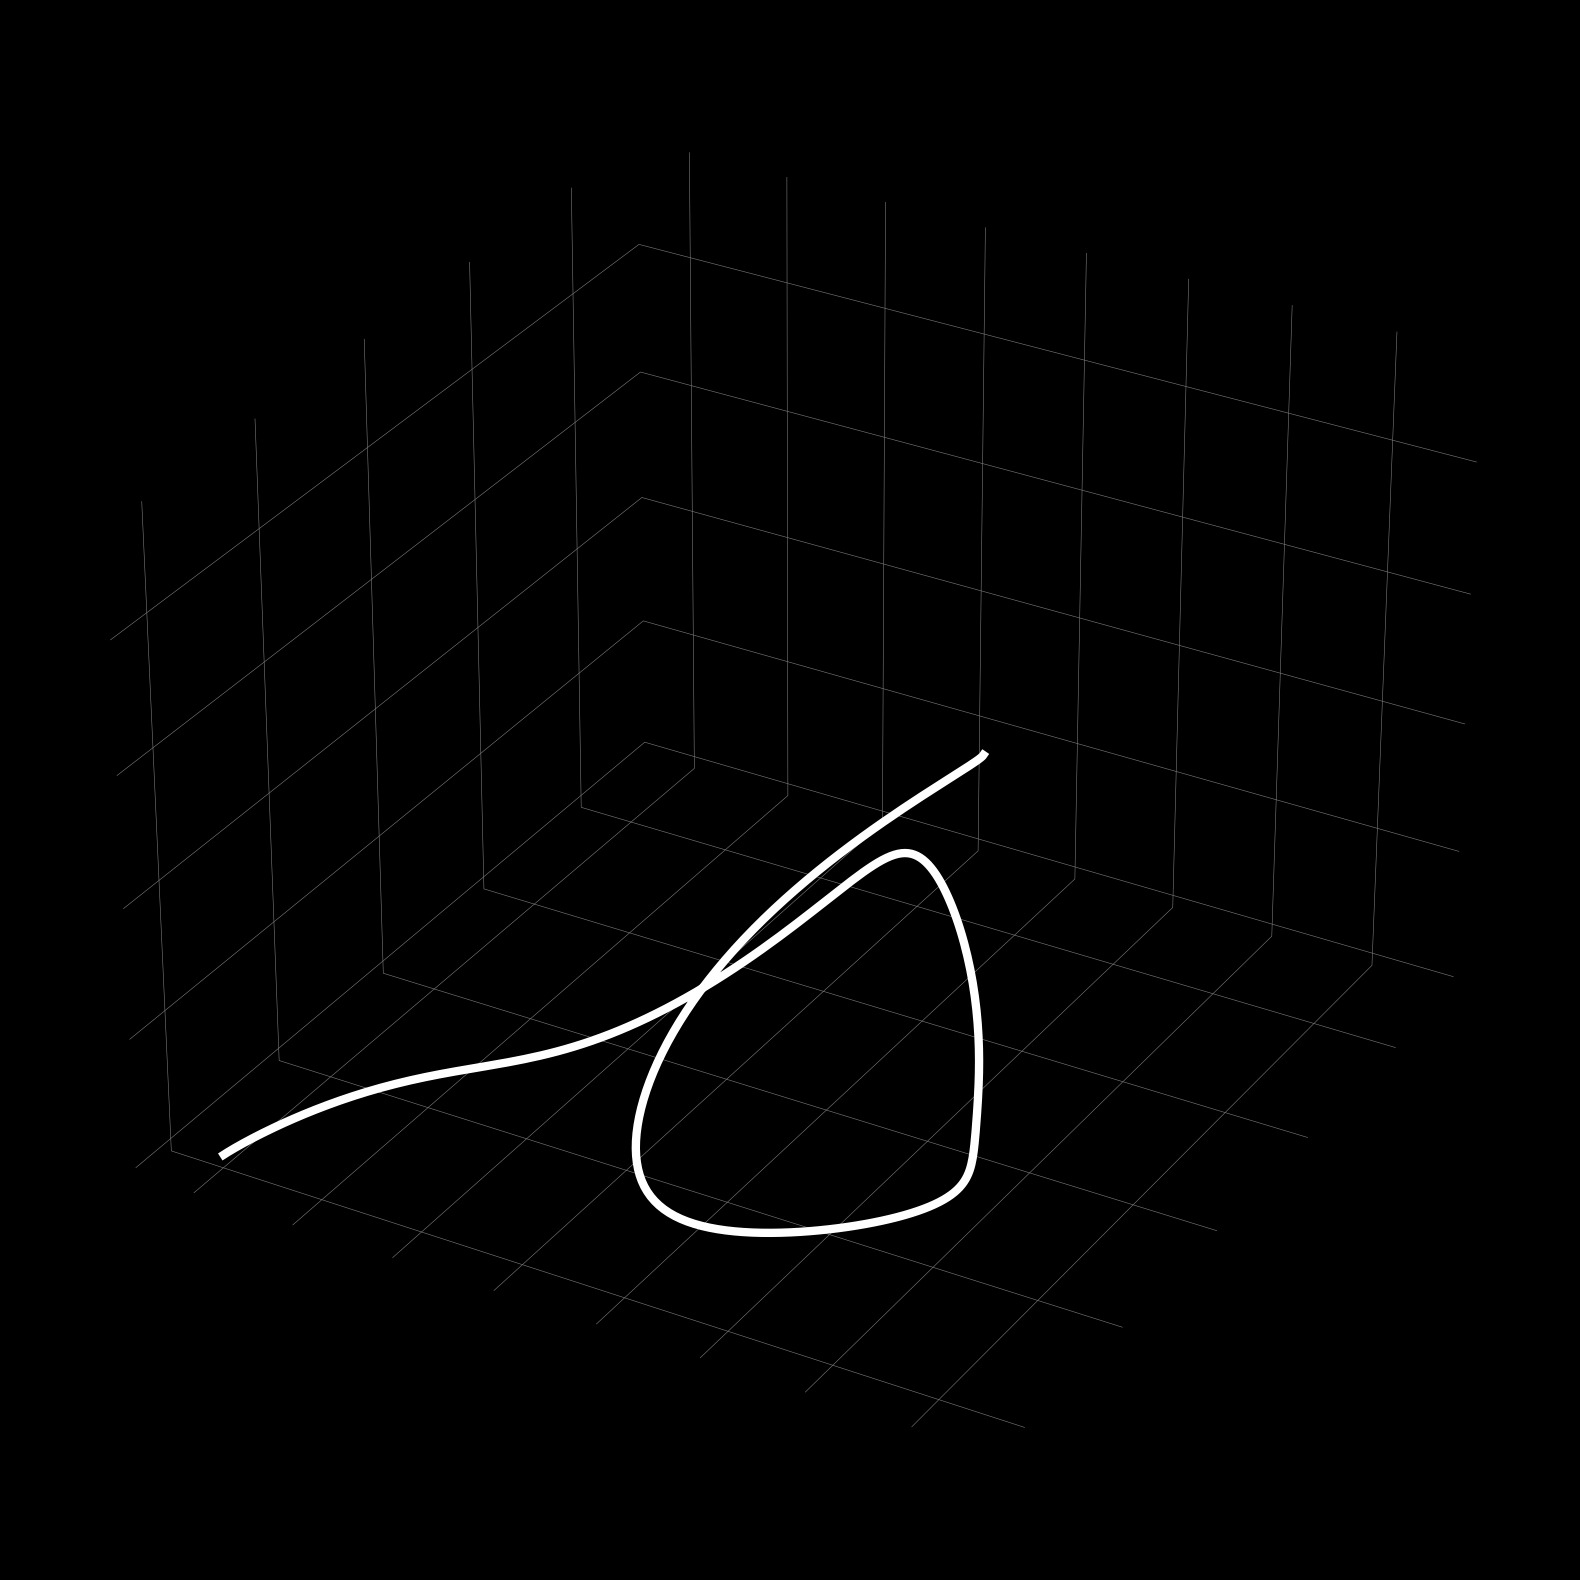

In [51]:
# 3D animation of the state space trajectory
fig, ax = plt.subplots(1,1, figsize=(10, 10), dpi=200, subplot_kw={'projection': '3d'})
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

ax.plot(inst_rates[0], inst_rates[1], inst_rates[2], color='black', alpha=0)

line = ax.plot([], [], [], color='white', lw=3)[0]
def update(frame):
    line.set_data_3d(inst_rates[0][:frame], inst_rates[1][:frame], inst_rates[2][:frame])
    return line, 

# Remove gray panes
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Make panes transparent
ax.xaxis.pane.set_alpha(0)
ax.yaxis.pane.set_alpha(0)
ax.zaxis.pane.set_alpha(0)

# Adjust grid line width
# Customize grid lines
ax.xaxis._axinfo["grid"].update({"linewidth": 0.2, "color": "grey"})
ax.yaxis._axinfo["grid"].update({"linewidth": 0.2, "color": "grey"})
ax.zaxis._axinfo["grid"].update({"linewidth": 0.2, "color": "grey"})


#update(len(t)-1)
anim = FuncAnimation(fig, update, frames=tqdm(range(len(t))), blit=True, interval=30)
anim.save(save_folder / 'state_space_trajectory.mp4')